# NCI GDC Data Analysis

Datasets were pulled from https://portal.gdc.cancer.gov/analysis_page?app=CohortBuilder&tab=general_diagnosis 
They were filtered for Breast Cancer before pulled. Need to check with Arjita on the exact process of that

## Load Packages

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import requests
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('future.no_silent_downcasting', True)

/Users/arjita/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Import Data from Github

Pull in gene dataset. 

In [2]:
response = requests.get('https://raw.githubusercontent.com/aaditya0106/cancer-dashboard/main/Data/HierCluster.2024-11-19.tsv')
if response.status_code == 200:
    gene = pd.read_csv(StringIO(response.text), sep='\t')
    print("Data loaded successfully!")
else:
    print(f"Failed to fetch data: {response.status_code}")

Data loaded successfully!


Pull in clinical dataset.

In [3]:
response = requests.get('https://raw.githubusercontent.com/aaditya0106/cancer-dashboard/main/Data/clinical.tsv')
if response.status_code == 200:
    clinical = pd.read_csv(StringIO(response.text), sep='\t')
    print("Data loaded successfully!")
else:
    print(f"Failed to fetch data: {response.status_code}")

Data loaded successfully!


## Basic gene data exploration

In [4]:
gene.head()

,Case,ANO1,CTTN,GAB2,TSKU,PEG10,TSPAN12,VSIG2,INHBB,CLU,...,DSG2,PGGHG,MYH14,PTPRU,CEP170B,TRPM4,AGRN,LAMA5,SLC17A9,SMIM24
0,TCGA-AC-A2QJ,-0.850784,-0.067790,-0.373197,0.353471,-0.424534,-0.627105,-0.225790,-0.428333,-0.396251,...,-1.360506,-0.405373,-1.069204,-0.642400,-0.293741,-0.317442,1.454789,-0.886521,2.645691,0.438836
1,TCGA-FA-A7DS,-0.903327,-0.984412,-0.434487,-0.533308,-0.510474,-0.649774,-0.417569,-0.591520,-0.415010,...,-1.479773,-0.243668,-1.159843,-1.038820,-1.792239,2.025728,-1.518411,-0.801080,4.244228,-0.274578
2,TCGA-A2-A4S1,-0.749352,-0.266099,-0.379331,0.198941,-0.155934,-0.530950,-0.325875,-0.373839,-0.306217,...,-1.429917,0.136463,-1.169063,-0.786902,-0.390244,-0.130008,0.732697,-0.683839,0.121208,-0.107634
3,TCGA-AR-A5QQ,0.292535,-0.049525,-0.475821,0.243683,-0.502936,-0.565909,-0.318526,-0.471878,-0.377541,...,-0.485598,-0.440984,-0.992049,-0.228702,-0.046550,-1.026940,1.468554,-0.556163,-0.100514,-0.221282
4,TCGA-E9-A5FL,-0.787100,0.226868,-0.429163,0.435614,-0.384482,-0.507950,0.562074,-0.480450,-0.251577,...,-0.915629,1.068320,-0.543074,-0.115328,0.107458,-0.455221,0.150628,0.788012,-0.333208,1.210650


In [5]:
gene.shape

(1000, 1001)

In [6]:
gene.dtypes

Case        object
ANO1       float64
CTTN       float64
GAB2       float64
TSKU       float64
            ...   
TRPM4      float64
AGRN       float64
LAMA5      float64
SLC17A9    float64
SMIM24     float64
Length: 1001, dtype: object

Determine if any values are Null. There are no null values and there are no duplicate samples. 

In [7]:
gene.isnull().any().value_counts()

False    1001
Name: count, dtype: int64

In [8]:
gene['Case'].duplicated().sum()

0

## Basic clinical data exploration

In [9]:
clinical.head()

,case_id,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_birth,country_of_residence_at_enrollment,days_to_birth,...,treatment_dose_units,treatment_duration,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_outcome_duration,treatment_type
0,00016c8f-a0be-4319-9c42-4f3bcd90ac92,AD1602,FM-AD,'--,'--,'--,'--,'--,'--,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--
1,001cef41-ff86-4d3f-a140-a647ac4b10a1,TCGA-E2-A1IU,TCGA-BRCA,60,'--,'--,'--,'--,'--,-22279,...,'--,'--,'--,'--,'--,'--,no,'--,'--,"Radiation Therapy, NOS"
2,001cef41-ff86-4d3f-a140-a647ac4b10a1,TCGA-E2-A1IU,TCGA-BRCA,60,'--,'--,'--,'--,'--,-22279,...,'--,'--,'--,'--,'--,'--,yes,'--,'--,"Pharmaceutical Therapy, NOS"
3,002cdb51-32c0-40be-b92f-60961f091bdf,AD16494,FM-AD,'--,'--,'--,'--,'--,'--,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--
4,0045349c-69d9-4306-a403-c9c1fa836644,TCGA-A1-A0SB,TCGA-BRCA,70,'--,'--,'--,'--,'--,-25833,...,'--,'--,'--,'--,'--,'--,not reported,'--,'--,"Radiation Therapy, NOS"


In [10]:
clinical.columns

Index(['case_id', 'case_submitter_id', 'project_id', 'age_at_index',
       'age_is_obfuscated', 'cause_of_death', 'cause_of_death_source',
       'country_of_birth', 'country_of_residence_at_enrollment',
       'days_to_birth',
       ...
       'treatment_dose_units', 'treatment_duration', 'treatment_effect',
       'treatment_effect_indicator', 'treatment_frequency',
       'treatment_intent_type', 'treatment_or_therapy', 'treatment_outcome',
       'treatment_outcome_duration', 'treatment_type'],
      dtype='object', length=219)

In [11]:
clinical.shape

(5268, 219)

Make sure tissue of origin is breast related. These are the types of tissues currently included. 

In [12]:
# Generate the summary table of what tissue_or_organ_of_origin is
summary_table = clinical['tissue_or_organ_of_origin'].value_counts()

# Display the summary table
print(summary_table)

tissue_or_organ_of_origin
Breast, NOS                       5175
Not Reported                        72
Lower-inner quadrant of breast       6
Upper-inner quadrant of breast       4
Upper-outer quadrant of breast       4
Overlapping lesion of breast         4
Lower-outer quadrant of breast       2
'--                                  1
Name: count, dtype: int64


Remove rows where tissue or organ of origin are Not Reported or '--

In [13]:
clinicalBreast = clinical[~clinical['tissue_or_organ_of_origin'].isin(['Not Reported', "'--"])]

# Check the result
print(clinicalBreast['tissue_or_organ_of_origin'].value_counts())


tissue_or_organ_of_origin
Breast, NOS                       5175
Lower-inner quadrant of breast       6
Upper-inner quadrant of breast       4
Upper-outer quadrant of breast       4
Overlapping lesion of breast         4
Lower-outer quadrant of breast       2
Name: count, dtype: int64


In [14]:
clinicalBreast.head()

,case_id,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_birth,country_of_residence_at_enrollment,days_to_birth,...,treatment_dose_units,treatment_duration,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_outcome_duration,treatment_type
0,00016c8f-a0be-4319-9c42-4f3bcd90ac92,AD1602,FM-AD,'--,'--,'--,'--,'--,'--,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--
1,001cef41-ff86-4d3f-a140-a647ac4b10a1,TCGA-E2-A1IU,TCGA-BRCA,60,'--,'--,'--,'--,'--,-22279,...,'--,'--,'--,'--,'--,'--,no,'--,'--,"Radiation Therapy, NOS"
2,001cef41-ff86-4d3f-a140-a647ac4b10a1,TCGA-E2-A1IU,TCGA-BRCA,60,'--,'--,'--,'--,'--,-22279,...,'--,'--,'--,'--,'--,'--,yes,'--,'--,"Pharmaceutical Therapy, NOS"
3,002cdb51-32c0-40be-b92f-60961f091bdf,AD16494,FM-AD,'--,'--,'--,'--,'--,'--,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--
4,0045349c-69d9-4306-a403-c9c1fa836644,TCGA-A1-A0SB,TCGA-BRCA,70,'--,'--,'--,'--,'--,-25833,...,'--,'--,'--,'--,'--,'--,not reported,'--,'--,"Radiation Therapy, NOS"


Check that 73 invalid rows were removed

In [15]:
clinicalBreast.shape

(5195, 219)

Get number of duplicate case_submitter_id numbers. These are patients with multiple rows of data.

In [16]:
clinicalBreast['case_submitter_id'].duplicated().sum()

1148

Get a table of the duplicates

In [17]:
# Identify all rows with duplicates
all_duplicates = clinicalBreast[clinicalBreast['case_submitter_id'].duplicated(keep=False)]

## Merge gene and clinicalBreast

In [18]:
geneClinical = gene.merge(clinicalBreast, left_on='Case', right_on='case_submitter_id', how='inner')

In [19]:
geneClinical.shape

(1854, 1220)

Check results for a duplicate case_submitter_id. We want to make sure each case_submitter_id/case always gets the same gene expression data

In [20]:
geneClinical['case_submitter_id'].duplicated().sum()

855

Get a table of the duplicates

In [21]:
# Identify all rows with duplicates
all_duplicatesMerge = geneClinical[geneClinical['case_submitter_id'].duplicated(keep=False)]

In [22]:
all_duplicatesMerge.head()

,Case,ANO1,CTTN,GAB2,TSKU,PEG10,TSPAN12,VSIG2,INHBB,CLU,...,treatment_dose_units,treatment_duration,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_outcome_duration,treatment_type
0,TCGA-AC-A2QJ,-0.850784,-0.067790,-0.373197,0.353471,-0.424534,-0.627105,-0.225790,-0.428333,-0.396251,...,'--,'--,'--,'--,'--,'--,yes,'--,'--,"Radiation Therapy, NOS"
1,TCGA-AC-A2QJ,-0.850784,-0.067790,-0.373197,0.353471,-0.424534,-0.627105,-0.225790,-0.428333,-0.396251,...,'--,'--,'--,'--,'--,'--,yes,'--,'--,"Pharmaceutical Therapy, NOS"
2,TCGA-FA-A7DS,-0.903327,-0.984412,-0.434487,-0.533308,-0.510474,-0.649774,-0.417569,-0.591520,-0.415010,...,'--,'--,'--,'--,'--,'--,no,'--,'--,"Radiation Therapy, NOS"
3,TCGA-FA-A7DS,-0.903327,-0.984412,-0.434487,-0.533308,-0.510474,-0.649774,-0.417569,-0.591520,-0.415010,...,'--,'--,'--,'--,'--,'--,yes,'--,'--,"Pharmaceutical Therapy, NOS"
4,TCGA-A2-A4S1,-0.749352,-0.266099,-0.379331,0.198941,-0.155934,-0.530950,-0.325875,-0.373839,-0.306217,...,'--,'--,'--,'--,'--,'--,yes,'--,'--,"Radiation Therapy, NOS"


If I drop clinical columns, then drop duplicates. Do I get a table 1000 rows long?

In [23]:
short = geneClinical.iloc[:, 0:1001]
short.shape

(1854, 1001)

In [24]:
short.columns

Index(['Case', 'ANO1', 'CTTN', 'GAB2', 'TSKU', 'PEG10', 'TSPAN12', 'VSIG2',
       'INHBB', 'CLU',
       ...
       'DSG2', 'PGGHG', 'MYH14', 'PTPRU', 'CEP170B', 'TRPM4', 'AGRN', 'LAMA5',
       'SLC17A9', 'SMIM24'],
      dtype='object', length=1001)

In [25]:
shortNoDup = short.drop_duplicates()
shortNoDup.shape

(999, 1001)

I have less than the 1000 samples I started with. Check what happened to one sample. 

In [26]:
# Get indices where 'Case' in 'gene' is not in 'shortNoDup'
indices_not_in_shortNoDup = gene[~gene['Case'].isin(shortNoDup['Case'])].index

# Print the result
print(indices_not_in_shortNoDup)


Index([697], dtype='int64')


In [27]:
# print rows that do not have a case in the merged dataset
gene.iloc[indices_not_in_shortNoDup, :]

,Case,ANO1,CTTN,GAB2,TSKU,PEG10,TSPAN12,VSIG2,INHBB,CLU,...,DSG2,PGGHG,MYH14,PTPRU,CEP170B,TRPM4,AGRN,LAMA5,SLC17A9,SMIM24
697,TCGA-BH-A0B2,-0.335215,-0.533468,-0.303364,-0.265946,-0.48188,-0.443199,-0.26824,-0.563447,-0.012233,...,-0.189918,-0.225109,-0.636121,-0.661413,0.303512,-0.515584,0.059583,-0.343663,-0.444788,0.077625


In [28]:
gene[gene['Case'] == 'TCGA-BH-A0B2']

,Case,ANO1,CTTN,GAB2,TSKU,PEG10,TSPAN12,VSIG2,INHBB,CLU,...,DSG2,PGGHG,MYH14,PTPRU,CEP170B,TRPM4,AGRN,LAMA5,SLC17A9,SMIM24
697,TCGA-BH-A0B2,-0.335215,-0.533468,-0.303364,-0.265946,-0.48188,-0.443199,-0.26824,-0.563447,-0.012233,...,-0.189918,-0.225109,-0.636121,-0.661413,0.303512,-0.515584,0.059583,-0.343663,-0.444788,0.077625


In [29]:
clinicalBreast[clinicalBreast['case_submitter_id'] == 'TCGA-BH-A0B2']

,case_id,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_birth,country_of_residence_at_enrollment,days_to_birth,...,treatment_dose_units,treatment_duration,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_outcome_duration,treatment_type


In [30]:
clinical[clinical['case_submitter_id'] == 'TCGA-BH-A0B2']

,case_id,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_birth,country_of_residence_at_enrollment,days_to_birth,...,treatment_dose_units,treatment_duration,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_outcome_duration,treatment_type
1810,57a1604c-60b7-4b30-a75e-f70939532c5c,TCGA-BH-A0B2,TCGA-BRCA,'--,'--,'--,'--,'--,'--,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--


Case 'TCGA-BH-A0B2' was in clinical. However, the tissue or ogan was equal to '-- so it got removed when I created breastClinical. It is rightfully not present in the merged data

## Explore the merged data

In [31]:
geneClinical2 = geneClinical.replace("'--", np.NaN)

In [32]:
# Report the number of nulls per column
null_counts = geneClinical2.isnull().sum()


In [33]:
# Filter columns where the number of nulls is <= 1800 (Total number of rows is 1854)
columns_to_keep = null_counts[null_counts <= 1800].index

# Select only the columns to keep
filtered_geneClinical = geneClinical2[columns_to_keep]

print(f"Columns removed: {set(geneClinical2.columns) - set(filtered_geneClinical.columns)}")
print(f"Filtered DataFrame shape: {filtered_geneClinical.shape}")


Columns removed: {'cancer_detection_method', 'lesions_treated_number', 'tumor_focality', 'satellite_nodule_present', 'wilms_tumor_histologic_subtype', 'prescribed_dose_units', 'age_is_obfuscated', 'method_of_diagnosis', 'ajcc_clinical_t', 'cog_renal_stage', 'melanoma_known_primary', 'therapeutic_agents', 'laterality', 'enneking_msts_grade', 'ensat_pathologic_t', 'metastasis_at_diagnosis_site', 'gastric_esophageal_junction_involvement', 'uicc_staging_system_edition', 'country_of_birth', 'peripancreatic_lymph_nodes_positive', 'treatment_dose_units', 'treatment_outcome_duration', 'international_prognostic_index', 'first_symptom_longest_duration', 'occupation_duration_years', 'margins_involved_site', 'treatment_dose', 'number_of_cycles', 'perineural_invasion_present', 'fab_morphology_code', 'max_tumor_bulk_site', 'who_cns_grade', 'papillary_renal_cell_type', 'therapeutic_level_achieved', 'uicc_pathologic_t', 'primary_gleason_grade', 'ann_arbor_pathologic_stage', 'ajcc_clinical_stage', 'pre

There are 1854 rows. When we removed columns that had >1800 nulls then we removed 184 columns. Now checking if there are other columns that have a high percentage of nulls

In [34]:
filtered_geneClinical.isnull().sum().sort_values(ascending = False)

year_of_death                  1690
days_to_death                  1615
ajcc_staging_system_edition     391
days_to_last_follow_up          332
ajcc_pathologic_stage           180
                               ... 
COL7A1                            0
ITGB4                             0
RGS2                              0
IGSF3                             0
THBD                              0
Length: 1036, dtype: int64

I am going to remove year_of_death and days_to_death as these are at best 87% null. After those that amount of nulls drops sharply so I will keep those clinical columns

In [35]:
# Drop the specified columns from the DataFrame
filtered_geneClinical2 = filtered_geneClinical.drop(['year_of_death', 'days_to_death'], axis=1)

# Display the updated DataFrame shape
print(filtered_geneClinical2.shape)


(1854, 1034)


## Select 30 genes due to Tableau display limitations

Normalize gene expression values. 

In [36]:
# select only the columns with gene expression data
df = filtered_geneClinical2.iloc[:, 1:1001]
df.head()

,ANO1,CTTN,GAB2,TSKU,PEG10,TSPAN12,VSIG2,INHBB,CLU,SCARA3,...,DSG2,PGGHG,MYH14,PTPRU,CEP170B,TRPM4,AGRN,LAMA5,SLC17A9,SMIM24
0,-0.850784,-0.067790,-0.373197,0.353471,-0.424534,-0.627105,-0.225790,-0.428333,-0.396251,-0.612892,...,-1.360506,-0.405373,-1.069204,-0.642400,-0.293741,-0.317442,1.454789,-0.886521,2.645691,0.438836
1,-0.850784,-0.067790,-0.373197,0.353471,-0.424534,-0.627105,-0.225790,-0.428333,-0.396251,-0.612892,...,-1.360506,-0.405373,-1.069204,-0.642400,-0.293741,-0.317442,1.454789,-0.886521,2.645691,0.438836
2,-0.903327,-0.984412,-0.434487,-0.533308,-0.510474,-0.649774,-0.417569,-0.591520,-0.415010,-0.941964,...,-1.479773,-0.243668,-1.159843,-1.038820,-1.792239,2.025728,-1.518411,-0.801080,4.244228,-0.274578
3,-0.903327,-0.984412,-0.434487,-0.533308,-0.510474,-0.649774,-0.417569,-0.591520,-0.415010,-0.941964,...,-1.479773,-0.243668,-1.159843,-1.038820,-1.792239,2.025728,-1.518411,-0.801080,4.244228,-0.274578
4,-0.749352,-0.266099,-0.379331,0.198941,-0.155934,-0.530950,-0.325875,-0.373839,-0.306217,-0.559285,...,-1.429917,0.136463,-1.169063,-0.786902,-0.390244,-0.130008,0.732697,-0.683839,0.121208,-0.107634


In [64]:
df

,ANO1,CTTN,GAB2,TSKU,PEG10,TSPAN12,VSIG2,INHBB,CLU,SCARA3,...,DSG2,PGGHG,MYH14,PTPRU,CEP170B,TRPM4,AGRN,LAMA5,SLC17A9,SMIM24
0,-0.850784,-0.067790,-0.373197,0.353471,-0.424534,-0.627105,-0.225790,-0.428333,-0.396251,-0.612892,...,-1.360506,-0.405373,-1.069204,-0.642400,-0.293741,-0.317442,1.454789,-0.886521,2.645691,0.438836
1,-0.850784,-0.067790,-0.373197,0.353471,-0.424534,-0.627105,-0.225790,-0.428333,-0.396251,-0.612892,...,-1.360506,-0.405373,-1.069204,-0.642400,-0.293741,-0.317442,1.454789,-0.886521,2.645691,0.438836
2,-0.903327,-0.984412,-0.434487,-0.533308,-0.510474,-0.649774,-0.417569,-0.591520,-0.415010,-0.941964,...,-1.479773,-0.243668,-1.159843,-1.038820,-1.792239,2.025728,-1.518411,-0.801080,4.244228,-0.274578
3,-0.903327,-0.984412,-0.434487,-0.533308,-0.510474,-0.649774,-0.417569,-0.591520,-0.415010,-0.941964,...,-1.479773,-0.243668,-1.159843,-1.038820,-1.792239,2.025728,-1.518411,-0.801080,4.244228,-0.274578
4,-0.749352,-0.266099,-0.379331,0.198941,-0.155934,-0.530950,-0.325875,-0.373839,-0.306217,-0.559285,...,-1.429917,0.136463,-1.169063,-0.786902,-0.390244,-0.130008,0.732697,-0.683839,0.121208,-0.107634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849,-0.577276,-0.437856,0.104747,-0.360682,-0.397765,-0.035058,-0.335168,1.239598,-0.256468,-0.536369,...,-0.255819,-0.408291,-0.804534,-0.238473,1.191062,-0.546254,1.930648,1.327399,-0.333002,-0.294545
1850,-0.570485,-0.094027,0.898617,-0.496092,0.028231,1.127175,-0.327414,-0.614096,-0.469461,-0.811686,...,-0.921805,-0.416384,-1.094392,-0.957513,-1.642254,-0.618281,-1.266342,-1.116794,3.498732,-0.016055
1851,0.932538,0.324994,0.465619,-0.448832,-0.404929,0.472066,-0.143123,-0.609882,-0.396159,-0.387849,...,-1.403157,-0.158240,-1.033908,-0.291036,0.039150,1.579099,3.366505,1.233683,0.138862,0.015622
1852,0.883997,0.204858,0.495980,-0.501540,-0.464307,0.829832,0.406161,-0.664142,-0.397878,-0.752201,...,-1.185030,-0.242768,-0.958054,-0.548833,-0.750321,0.418194,-0.662466,-0.178567,-0.293042,0.285554


Check how the values within expression are distributed. It appears they have already had a zscale normalization

In [37]:
df.describe()

,ANO1,CTTN,GAB2,TSKU,PEG10,TSPAN12,VSIG2,INHBB,CLU,SCARA3,...,DSG2,PGGHG,MYH14,PTPRU,CEP170B,TRPM4,AGRN,LAMA5,SLC17A9,SMIM24
count,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,...,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000
mean,-0.042017,-0.031159,-0.002537,0.035314,0.015311,0.015453,0.003831,0.042372,0.023642,0.041370,...,0.006282,-0.038562,-0.025868,-0.004840,-0.077585,-0.083749,0.000017,-0.028731,-0.016722,-0.015515
std,0.946605,0.995601,1.027498,1.030280,1.018445,1.028501,1.028194,1.025184,1.034444,1.023584,...,1.015433,0.930549,0.971065,1.014431,0.935817,0.887914,1.006107,0.998272,1.012380,0.993762
min,-0.907599,-0.984412,-0.590751,-0.567719,-0.512177,-0.717005,-0.449186,-0.702381,-0.478979,-1.011691,...,-1.497170,-0.613398,-1.183664,-1.065260,-1.855873,-1.235358,-1.546819,-1.222995,-0.644641,-0.324721
25%,-0.587943,-0.459994,-0.351897,-0.364749,-0.491793,-0.466247,-0.416510,-0.478546,-0.334958,-0.580430,...,-0.614631,-0.514711,-0.608853,-0.629637,-0.688554,-0.630372,-0.691374,-0.605792,-0.490890,-0.253259
50%,-0.305595,-0.295415,-0.215921,-0.230250,-0.400690,-0.278502,-0.337263,-0.199083,-0.193071,-0.264849,...,-0.216286,-0.382874,-0.233680,-0.314676,-0.240961,-0.289620,-0.202239,-0.242559,-0.342845,-0.174742
75%,0.138393,-0.037386,-0.000003,0.032448,0.032737,0.068806,-0.087156,0.240975,0.087120,0.319227,...,0.361930,-0.011131,0.299686,0.258888,0.328498,0.218534,0.403774,0.271820,0.001558,-0.032232
max,9.833553,10.155726,18.408778,13.079163,7.136821,12.479516,8.994755,19.363065,25.873620,9.439862,...,6.738533,10.197265,12.509559,7.723142,7.667126,12.393779,5.619156,11.469196,10.522581,25.593419


In [175]:
# # Step 4: Concatenate all three DataFrames (columns) into a single dataset
# #combined_df = pd.concat([filtered_geneClinical2.iloc[:, 0], lowest_columns_df, closest_columns_df, highest_columns_df, filtered_geneClinical2.iloc[:, 1001:]], axis=1)
# combined_df = pd.concat([filtered_geneClinical2.iloc[:, 0], lowest_columns_df, closest_columns_df, highest_columns_df], axis=1)

# combined_df = combined_df.iloc[1:100, :]
# # Check the combined dataset
# print("Combined Dataset:")
# print(combined_df.head())


Combined Dataset:
           Case    ZNF460    JMJD1C    MYO15B      H1-4    PTPN13     DOCK8  \
1  TCGA-AC-A2QJ -0.459712 -0.835159 -0.405481 -0.364717 -0.719390 -0.575544   
2  TCGA-FA-A7DS -0.418185 -0.564656 -0.528449 -0.315927 -0.879971  0.884940   
3  TCGA-FA-A7DS -0.418185 -0.564656 -0.528449 -0.315927 -0.879971  0.884940   
4  TCGA-A2-A4S1 -0.444168 -0.626830 -0.186062 -0.378815  0.409918 -0.484448   
5  TCGA-A2-A4S1 -0.444168 -0.626830 -0.186062 -0.378815  0.409918 -0.484448   

   KIAA1217     LRRK2    H2AC20  ...  C1orf210  SLC25A23      KDF1   TMEM30B  \
1 -1.184278 -0.522422 -0.154486  ... -1.377201 -1.346133 -1.450447 -1.282813   
2 -1.031766  0.886133 -0.299449  ... -1.549372 -1.451501 -1.742006 -1.366734   
3 -1.031766  0.886133 -0.299449  ... -1.549372 -1.451501 -1.742006 -1.366734   
4 -1.176890 -0.438415 -0.373105  ... -1.538816 -1.346663 -1.765835 -1.356105   
5 -1.176890 -0.438415 -0.373105  ... -1.538816 -1.346663 -1.765835 -1.356105   

      NRSN2  MARCKSL1     

In [177]:
# reshaped_df = combined_df.melt(id_vars=['Case'], var_name='Gene', value_name='Expression')

In [195]:
# reshaped_dfNoDup = reshaped_df.drop_duplicates()

In [193]:
# a = x[x['Case'] == 'TCGA-AN-A0FL']
# a[a['Gene'] == "GMPR"]

,Case,Gene,Expression
1219,TCGA-AN-A0FL,GMPR,19.052012


In [197]:
# reshaped_dfNoDup.to_csv('gene.csv')


In [110]:
## Output to csv to plot in Tableau

In [72]:
# filtered_geneClinical2.to_csv('nciClean.csv')

In [ ]:
# geneColumns = geneClinical.iloc[:, 0:51]

In [ ]:
# geneColumns.drop_duplicates()
# # geneColumns.head()
# geneColumns.set_index(geneColumns.columns[0], inplace=True)

In [ ]:
# # Create the heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(geneColumns, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
# plt.title("Heatmap Example")
# plt.show()

Concatenate 30 genes with clinical data. Reduce down to 100 samples

In [38]:
combined_df = pd.concat([filtered_geneClinical2.iloc[:, 0:31], filtered_geneClinical2.iloc[:, 1002:]], axis=1)

#reduce to 100 samples
combined_df = combined_df.iloc[1:100, :]
# Check the combined dataset
print("Combined Dataset:")
print(combined_df.head())


Combined Dataset:
           Case      ANO1      CTTN      GAB2      TSKU     PEG10   TSPAN12  \
1  TCGA-AC-A2QJ -0.850784 -0.067790 -0.373197  0.353471 -0.424534 -0.627105   
2  TCGA-FA-A7DS -0.903327 -0.984412 -0.434487 -0.533308 -0.510474 -0.649774   
3  TCGA-FA-A7DS -0.903327 -0.984412 -0.434487 -0.533308 -0.510474 -0.649774   
4  TCGA-A2-A4S1 -0.749352 -0.266099 -0.379331  0.198941 -0.155934 -0.530950   
5  TCGA-A2-A4S1 -0.749352 -0.266099 -0.379331  0.198941 -0.155934 -0.530950   

      VSIG2     INHBB       CLU  ...  prior_malignancy  prior_treatment  \
1 -0.225790 -0.428333 -0.396251  ...                no               No   
2 -0.417569 -0.591520 -0.415010  ...                no               No   
3 -0.417569 -0.591520 -0.415010  ...                no               No   
4 -0.325875 -0.373839 -0.306217  ...                no               No   
5 -0.325875 -0.373839 -0.306217  ...                no               No   

   progression_or_recurrence  site_of_resection_or_biops

In [39]:
combined_df.columns

Index(['Case', 'ANO1', 'CTTN', 'GAB2', 'TSKU', 'PEG10', 'TSPAN12', 'VSIG2',
       'INHBB', 'CLU', 'SCARA3', 'ACKR3', 'SERPINF2', 'ERBB2', 'GRB7', 'ABCC3',
       'ITGA3', 'F2RL1', 'TMEM45B', 'GATM', 'HOXB7', 'PRR15L', 'APOC1', 'UCP2',
       'DUSP10', 'MGST1', 'AQP3', 'RAMP3', 'CA2', 'SERPINA1', 'H2AW',
       'case_submitter_id', 'project_id', 'age_at_index', 'days_to_birth',
       'ethnicity', 'gender', 'race', 'vital_status', 'year_of_birth',
       'age_at_diagnosis', 'ajcc_pathologic_m', 'ajcc_pathologic_n',
       'ajcc_pathologic_stage', 'ajcc_pathologic_t',
       'ajcc_staging_system_edition', 'classification_of_tumor',
       'days_to_diagnosis', 'days_to_last_follow_up', 'icd_10_code',
       'last_known_disease_status', 'morphology', 'primary_diagnosis',
       'prior_malignancy', 'prior_treatment', 'progression_or_recurrence',
       'site_of_resection_or_biopsy', 'synchronous_malignancy',
       'tissue_or_organ_of_origin', 'tumor_grade', 'year_of_diagnosis',
       'tr

In [40]:
# List of all columns except the gene expression columns
id_vars = [
    'Case', 'case_submitter_id', 'project_id', 'age_at_index', 'days_to_birth', 'ethnicity', 
    'gender', 'race', 'vital_status', 'year_of_birth', 'age_at_diagnosis', 'ajcc_pathologic_m',
    'ajcc_pathologic_n', 'ajcc_pathologic_stage', 'ajcc_pathologic_t', 'ajcc_staging_system_edition',
    'classification_of_tumor', 'days_to_diagnosis', 'days_to_last_follow_up', 'icd_10_code',
    'last_known_disease_status', 'morphology', 'primary_diagnosis', 'prior_malignancy', 'prior_treatment',
    'progression_or_recurrence', 'site_of_resection_or_biopsy', 'synchronous_malignancy', 
    'tissue_or_organ_of_origin', 'tumor_grade', 'year_of_diagnosis', 'treatment_or_therapy', 'treatment_type'
]

# Use melt to reshape the DataFrame
reshaped_df = combined_df.melt(id_vars=id_vars, var_name='Gene', value_name='Expression')

# Check the reshaped DataFrame
print(reshaped_df.head())


           Case case_submitter_id project_id age_at_index days_to_birth  \
0  TCGA-AC-A2QJ      TCGA-AC-A2QJ  TCGA-BRCA           48        -17569   
1  TCGA-FA-A7DS      TCGA-FA-A7DS  TCGA-DLBC           54        -20087   
2  TCGA-FA-A7DS      TCGA-FA-A7DS  TCGA-DLBC           54        -20087   
3  TCGA-A2-A4S1      TCGA-A2-A4S1  TCGA-BRCA           66        -24353   
4  TCGA-A2-A4S1      TCGA-A2-A4S1  TCGA-BRCA           66        -24353   

                ethnicity  gender   race vital_status year_of_birth  ...  \
0      hispanic or latino  female  white         Dead          1963  ...   
1  not hispanic or latino  female  asian        Alive          1959  ...   
2  not hispanic or latino  female  asian        Alive          1959  ...   
3  not hispanic or latino  female  white        Alive          1946  ...   
4  not hispanic or latino  female  white        Alive          1946  ...   

  progression_or_recurrence site_of_resection_or_biopsy  \
0              not reported      

In [41]:
reshaped_df_drop = reshaped_df.drop(columns='case_submitter_id')

In [42]:
reshaped_df_drop.duplicated().sum()

0

In [43]:
#reshaped_df_drop.to_csv("geneClinicalClean.csv")

In [44]:
reshaped_df

,Case,case_submitter_id,project_id,age_at_index,days_to_birth,ethnicity,gender,race,vital_status,year_of_birth,...,progression_or_recurrence,site_of_resection_or_biopsy,synchronous_malignancy,tissue_or_organ_of_origin,tumor_grade,year_of_diagnosis,treatment_or_therapy,treatment_type,Gene,Expression
0,TCGA-AC-A2QJ,TCGA-AC-A2QJ,TCGA-BRCA,48,-17569,hispanic or latino,female,white,Dead,1963,...,not reported,"Breast, NOS",No,"Breast, NOS",Not Reported,2011,yes,"Pharmaceutical Therapy, NOS",ANO1,-0.850784
1,TCGA-FA-A7DS,TCGA-FA-A7DS,TCGA-DLBC,54,-20087,not hispanic or latino,female,asian,Alive,1959,...,not reported,"Breast, NOS",No,"Breast, NOS",Not Reported,2013,no,"Radiation Therapy, NOS",ANO1,-0.903327
2,TCGA-FA-A7DS,TCGA-FA-A7DS,TCGA-DLBC,54,-20087,not hispanic or latino,female,asian,Alive,1959,...,not reported,"Breast, NOS",No,"Breast, NOS",Not Reported,2013,yes,"Pharmaceutical Therapy, NOS",ANO1,-0.903327
3,TCGA-A2-A4S1,TCGA-A2-A4S1,TCGA-BRCA,66,-24353,not hispanic or latino,female,white,Alive,1946,...,not reported,"Breast, NOS",No,"Breast, NOS",Not Reported,2012,yes,"Radiation Therapy, NOS",ANO1,-0.749352
4,TCGA-A2-A4S1,TCGA-A2-A4S1,TCGA-BRCA,66,-24353,not hispanic or latino,female,white,Alive,1946,...,not reported,"Breast, NOS",No,"Breast, NOS",Not Reported,2012,no,"Pharmaceutical Therapy, NOS",ANO1,-0.749352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965,TCGA-EW-A1P1,TCGA-EW-A1P1,TCGA-BRCA,68,-24923,hispanic or latino,female,white,Alive,1940,...,not reported,"Breast, NOS",No,"Breast, NOS",Not Reported,2008,yes,"Pharmaceutical Therapy, NOS",H2AW,-0.120367
2966,TCGA-A2-A0CO,TCGA-A2-A0CO,TCGA-BRCA,85,-31404,not hispanic or latino,female,white,Dead,1917,...,not reported,"Breast, NOS",No,"Breast, NOS",Not Reported,2002,yes,"Pharmaceutical Therapy, NOS",H2AW,-0.021195
2967,TCGA-A2-A0CO,TCGA-A2-A0CO,TCGA-BRCA,85,-31404,not hispanic or latino,female,white,Dead,1917,...,not reported,"Breast, NOS",No,"Breast, NOS",Not Reported,2002,yes,"Radiation Therapy, NOS",H2AW,-0.021195
2968,TCGA-AR-A2LN,TCGA-AR-A2LN,TCGA-BRCA,65,-23992,not hispanic or latino,female,white,Alive,1945,...,not reported,"Breast, NOS",No,"Breast, NOS",Not Reported,2010,yes,"Pharmaceutical Therapy, NOS",H2AW,-0.652839


In [45]:
unique_expression = reshaped_df.groupby(['Case', 'Gene'])['Expression'].first().unstack()

In [46]:
unique_expression = unique_expression.astype(float).fillna(0)  # To Ensure all values are numeric

In [47]:
unique_expression

Gene,ABCC3,ACKR3,ANO1,APOC1,AQP3,CA2,CLU,CTTN,DUSP10,ERBB2,...,PRR15L,RAMP3,SCARA3,SERPINA1,SERPINF2,TMEM45B,TSKU,TSPAN12,UCP2,VSIG2
Case,,,,,,,,,,,,,,,,,,,,,
ER-B1PU,-0.045023,-0.586864,-0.907599,-0.228153,-0.393294,0.079816,0.080477,-0.685137,-0.610679,-0.439791,...,-0.658016,-0.392005,-0.414537,-0.309348,-0.181082,-0.551756,-0.539980,0.251338,-0.869466,-0.319394
MBCProject_1037,0.961252,-0.721009,-0.631017,0.980195,-0.355389,-0.084171,-0.361796,-0.524917,0.559878,1.288808,...,-0.656139,-0.378329,-0.505737,-0.285743,-0.251205,-0.145836,-0.423794,-0.211445,-0.390667,-0.444638
MBCProject_1542,0.286342,-0.717298,-0.699201,-0.082009,-0.370838,-0.119778,-0.149715,-0.758737,-0.529960,-0.389757,...,-0.606829,-0.195101,-0.597529,-0.321613,0.067656,-0.384368,-0.521514,-0.329936,0.223387,0.125454
MBCProject_1819,0.880671,-0.697784,-0.556719,-0.388686,-0.361625,-0.029711,-0.177128,-0.449316,-0.556900,-0.357524,...,-0.636253,-0.208991,-0.595553,-0.307013,0.346663,-0.478453,-0.477323,0.677203,-0.405091,-0.264097
MBCProject_3159,0.160918,0.420206,-0.621328,-0.419311,-0.345664,-0.119353,-0.342870,-0.378176,-0.788626,-0.418767,...,-0.656412,-0.104212,-0.496912,-0.325692,0.527588,-0.525519,-0.530285,-0.342842,-0.554920,-0.006699
MBCProject_4424,-0.363664,-0.851063,-0.903833,-0.750162,-0.287691,-0.131517,-0.437617,-0.281002,-0.808958,3.304599,...,-0.614746,-0.403834,-0.715864,-0.336051,-0.296450,-0.230278,-0.523506,-0.717005,-0.885184,-0.449186
MBCproject_0093,2.462503,-0.821065,1.088591,-0.530109,-0.080048,-0.125738,0.067390,1.721424,3.252885,4.305067,...,-0.655327,-0.403834,-0.965292,0.046882,1.040081,0.369532,-0.567719,2.806989,-0.876076,-0.449186
MBCproject_0280,0.417540,-0.687530,-0.100600,-0.454301,-0.077728,-0.120369,-0.271881,-0.467759,-0.541961,-0.265922,...,-0.610674,-0.178937,-0.658638,-0.274270,-0.000253,-0.414623,-0.545889,0.477848,-0.278416,-0.366658
TCGA-A1-A0SK,-0.439030,0.642108,-0.723427,-0.655918,-0.182672,-0.124400,-0.475469,-0.365973,-1.008591,-0.443459,...,-0.365946,-0.385397,-0.940958,-0.335134,-0.314658,0.002762,-0.411867,0.331586,-0.333276,0.379878


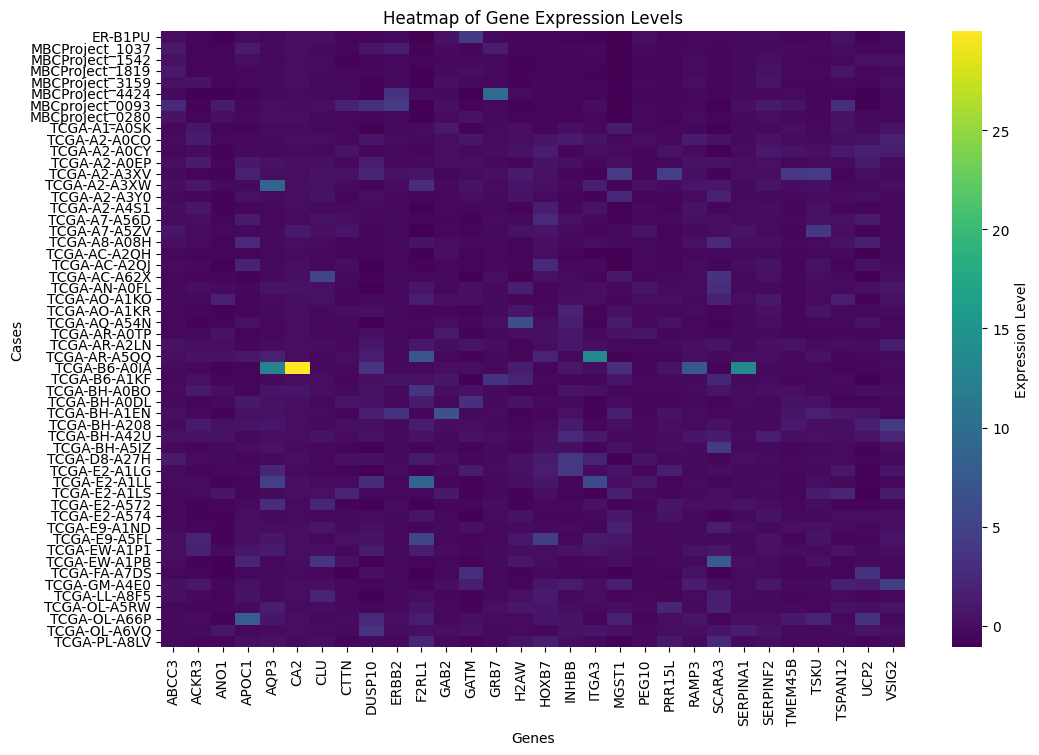

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn for a static heatmap as an alternative
plt.figure(figsize=(12, 8))
sns.heatmap(
    unique_expression,
    cmap="viridis",
    cbar_kws={'label': 'Expression Level'},
    xticklabels=True,
    yticklabels=True
)

plt.title("Heatmap of Gene Expression Levels")
plt.xlabel("Genes")
plt.ylabel("Cases")
plt.show()


In [49]:
unique_expression.reset_index(inplace=True)
unique_expression_melted = unique_expression.melt(id_vars='Case', var_name='Gene', value_name='Expression')

In [50]:
unique_expression

Gene,Case,ABCC3,ACKR3,ANO1,APOC1,AQP3,CA2,CLU,CTTN,DUSP10,...,PRR15L,RAMP3,SCARA3,SERPINA1,SERPINF2,TMEM45B,TSKU,TSPAN12,UCP2,VSIG2
0,ER-B1PU,-0.045023,-0.586864,-0.907599,-0.228153,-0.393294,0.079816,0.080477,-0.685137,-0.610679,...,-0.658016,-0.392005,-0.414537,-0.309348,-0.181082,-0.551756,-0.539980,0.251338,-0.869466,-0.319394
1,MBCProject_1037,0.961252,-0.721009,-0.631017,0.980195,-0.355389,-0.084171,-0.361796,-0.524917,0.559878,...,-0.656139,-0.378329,-0.505737,-0.285743,-0.251205,-0.145836,-0.423794,-0.211445,-0.390667,-0.444638
2,MBCProject_1542,0.286342,-0.717298,-0.699201,-0.082009,-0.370838,-0.119778,-0.149715,-0.758737,-0.529960,...,-0.606829,-0.195101,-0.597529,-0.321613,0.067656,-0.384368,-0.521514,-0.329936,0.223387,0.125454
3,MBCProject_1819,0.880671,-0.697784,-0.556719,-0.388686,-0.361625,-0.029711,-0.177128,-0.449316,-0.556900,...,-0.636253,-0.208991,-0.595553,-0.307013,0.346663,-0.478453,-0.477323,0.677203,-0.405091,-0.264097
4,MBCProject_3159,0.160918,0.420206,-0.621328,-0.419311,-0.345664,-0.119353,-0.342870,-0.378176,-0.788626,...,-0.656412,-0.104212,-0.496912,-0.325692,0.527588,-0.525519,-0.530285,-0.342842,-0.554920,-0.006699
5,MBCProject_4424,-0.363664,-0.851063,-0.903833,-0.750162,-0.287691,-0.131517,-0.437617,-0.281002,-0.808958,...,-0.614746,-0.403834,-0.715864,-0.336051,-0.296450,-0.230278,-0.523506,-0.717005,-0.885184,-0.449186
6,MBCproject_0093,2.462503,-0.821065,1.088591,-0.530109,-0.080048,-0.125738,0.067390,1.721424,3.252885,...,-0.655327,-0.403834,-0.965292,0.046882,1.040081,0.369532,-0.567719,2.806989,-0.876076,-0.449186
7,MBCproject_0280,0.417540,-0.687530,-0.100600,-0.454301,-0.077728,-0.120369,-0.271881,-0.467759,-0.541961,...,-0.610674,-0.178937,-0.658638,-0.274270,-0.000253,-0.414623,-0.545889,0.477848,-0.278416,-0.366658
8,TCGA-A1-A0SK,-0.439030,0.642108,-0.723427,-0.655918,-0.182672,-0.124400,-0.475469,-0.365973,-1.008591,...,-0.365946,-0.385397,-0.940958,-0.335134,-0.314658,0.002762,-0.411867,0.331586,-0.333276,0.379878
9,TCGA-A2-A0CO,-0.135141,1.102262,-0.364764,-0.249296,-0.279686,-0.058934,-0.008221,-0.415492,0.606770,...,-0.384279,1.151161,0.263677,-0.244249,0.272964,-0.135457,-0.245206,-0.015422,0.310716,1.642877


In [51]:
# heatmap = px.density_heatmap(
#     unique_expression_melted,
#     x="Gene",
#     y="Case",
#     z="Expression",
#     color_continuous_scale="Blues",
#     range_color=(-2, 30),
#     title="Heatmap of Gene Expression Levels",
#     labels={'Expression': 'Expression Level'}
# )
# heatmap_file_path = 'heatmap.html'
# heatmap.write_html(heatmap_file_path)

In [52]:
!pip install ipywidgets

/tmp/ipykernel_4170/423920191.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



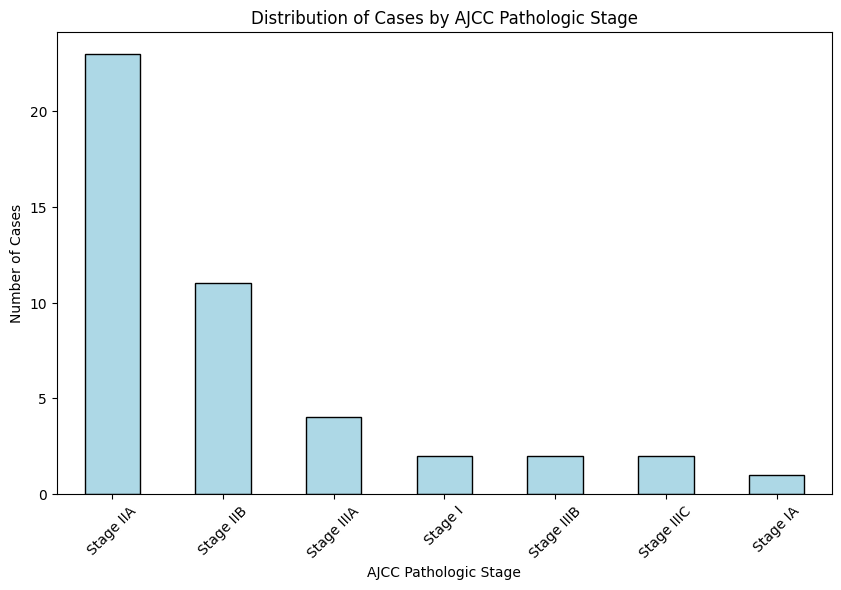

In [69]:
# Filter out "Unknown" values for AJCC columns
aggregated_data = reshaped_df.groupby(
    ['Case', 'ajcc_pathologic_stage', 'ajcc_pathologic_n', 'ajcc_pathologic_m', 'ajcc_pathologic_t'], as_index=False
).agg({'Expression': 'mean'})

filtered_data = aggregated_data[
    (reshaped_df['ajcc_pathologic_stage'] != "Unknown") &
    (reshaped_df['ajcc_pathologic_n'] != "Unknown") &
    (reshaped_df['ajcc_pathologic_m'] != "Unknown") &
    (reshaped_df['ajcc_pathologic_t'] != "Unknown")
]

# Distribution of Cases by AJCC Pathologic Stage
plt.figure(figsize=(10, 6))
filtered_data['ajcc_pathologic_stage'].value_counts().plot(kind='bar', color='lightblue', edgecolor='black')
plt.title("Distribution of Cases by AJCC Pathologic Stage")
plt.xlabel("AJCC Pathologic Stage")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.show()


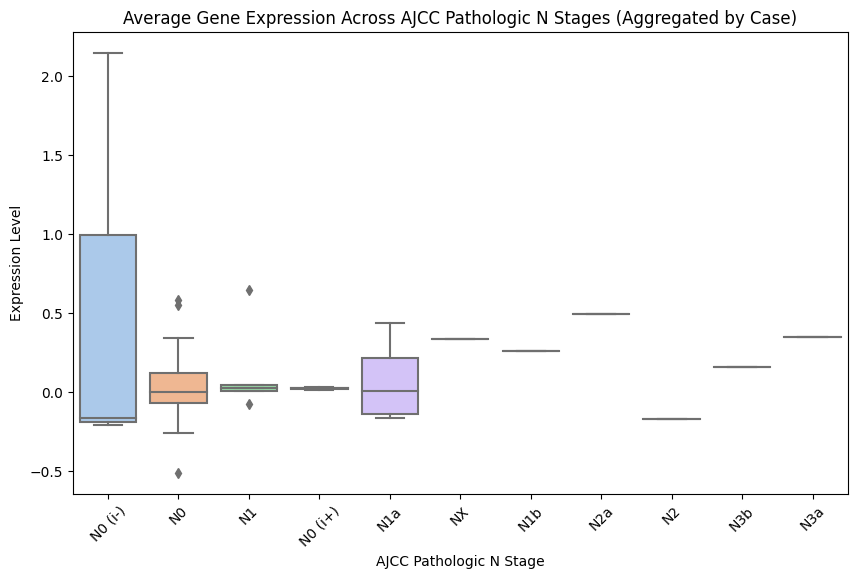

In [70]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_data, x='ajcc_pathologic_n', y='Expression', palette='pastel')
plt.title("Average Gene Expression Across AJCC Pathologic N Stages (Aggregated by Case)")
plt.xlabel("AJCC Pathologic N Stage")
plt.ylabel("Expression Level")
plt.xticks(rotation=45)
plt.show()

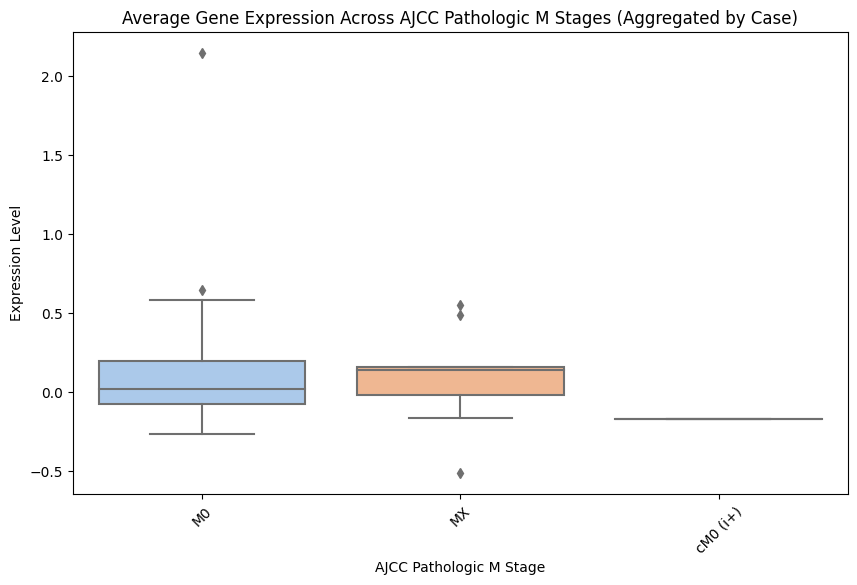

In [71]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_data, x='ajcc_pathologic_m', y='Expression', palette='pastel')
plt.title("Average Gene Expression Across AJCC Pathologic M Stages (Aggregated by Case)")
plt.xlabel("AJCC Pathologic M Stage")
plt.ylabel("Expression Level")
plt.xticks(rotation=45)
plt.show()

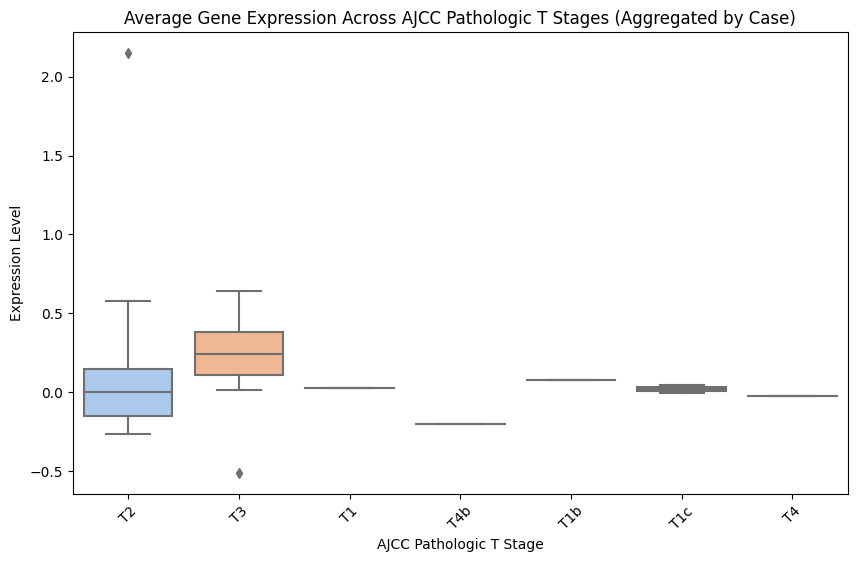

In [72]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_data, x='ajcc_pathologic_t', y='Expression', palette='pastel')
plt.title("Average Gene Expression Across AJCC Pathologic T Stages (Aggregated by Case)")
plt.xlabel("AJCC Pathologic T Stage")
plt.ylabel("Expression Level")
plt.xticks(rotation=45)
plt.show()

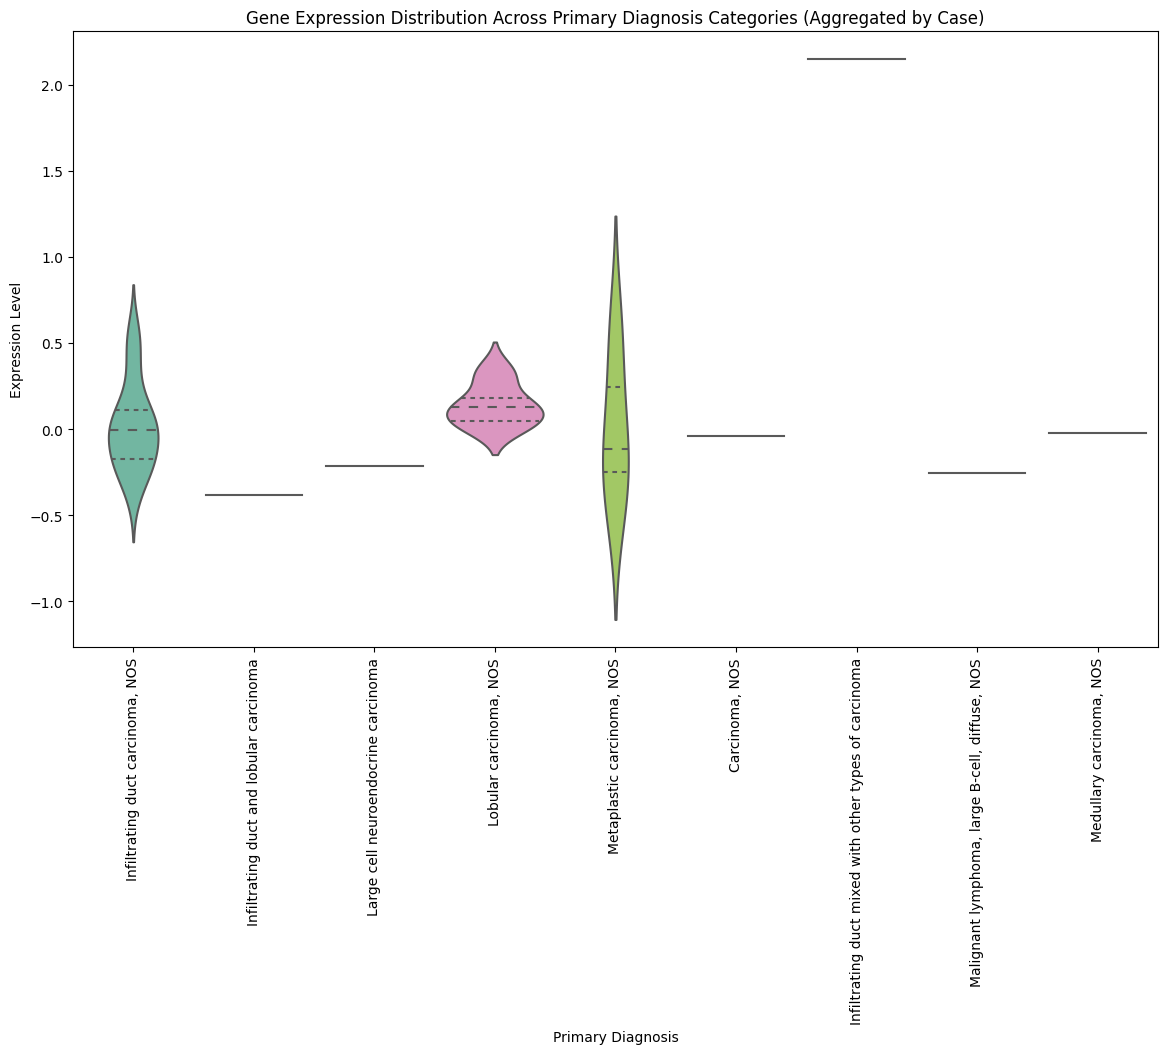

In [78]:
# Aggregate data by case (mean expression for cases with multiple rows)
aggregated_data = reshaped_df.groupby(['Case', 'primary_diagnosis'], as_index=False).agg({'Expression': 'mean'})

# Remove "Not Reported" values from the primary diagnosis column
filtered_data = aggregated_data[aggregated_data['primary_diagnosis'] != "Not Reported"]

# Create a violin plot
plt.figure(figsize=(14, 8))
sns.violinplot(data=filtered_data, x='primary_diagnosis', y='Expression', palette='Set2', inner='quartile')
plt.title("Gene Expression Distribution Across Primary Diagnosis Categories (Aggregated by Case)")
plt.xlabel("Primary Diagnosis")
plt.ylabel("Expression Level")
plt.xticks(rotation=90)
plt.show()
